C:\Users\student\AppData\Local\Temp\ipykernel_3796\3758896958.py:132: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.   3.75]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  schedule_sorted.loc[worker_mask, '開始時間'] = hours_cumsum - schedule_sorted.loc[worker_mask, '工作時數']


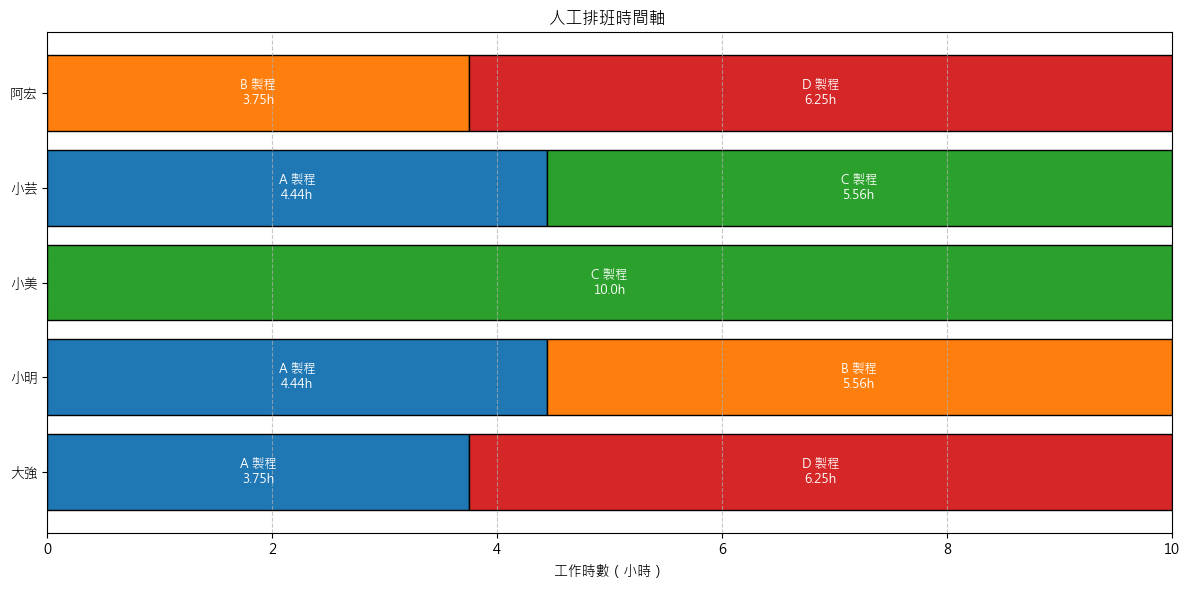

C:\Users\student\AppData\Local\Temp\ipykernel_3796\3758896958.py:132: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.  7.5]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  schedule_sorted.loc[worker_mask, '開始時間'] = hours_cumsum - schedule_sorted.loc[worker_mask, '工作時數']


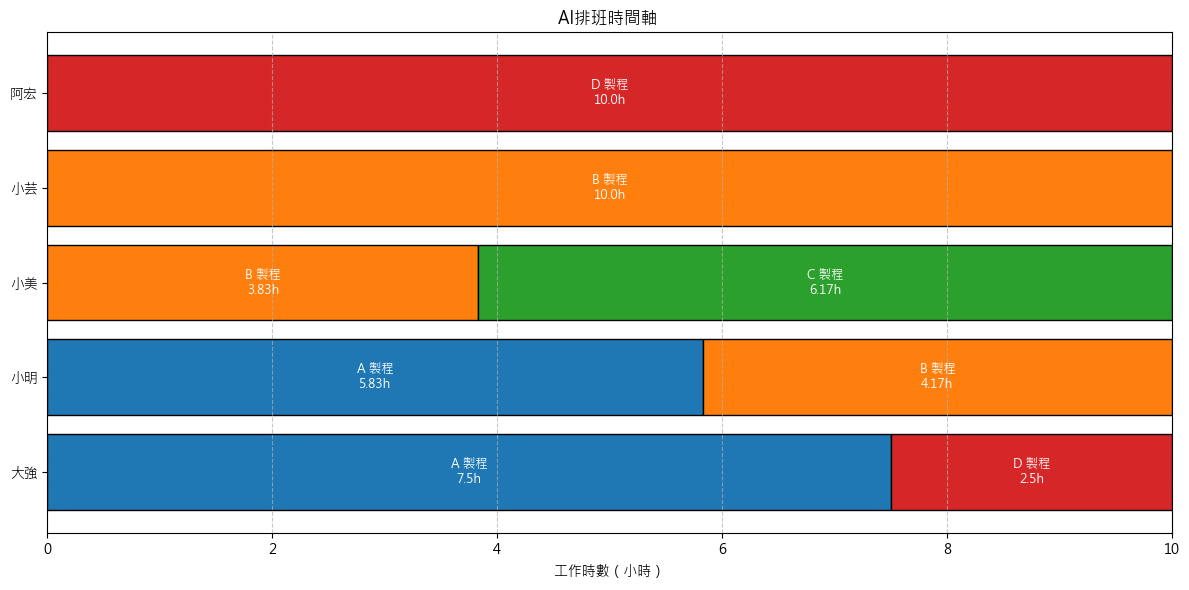

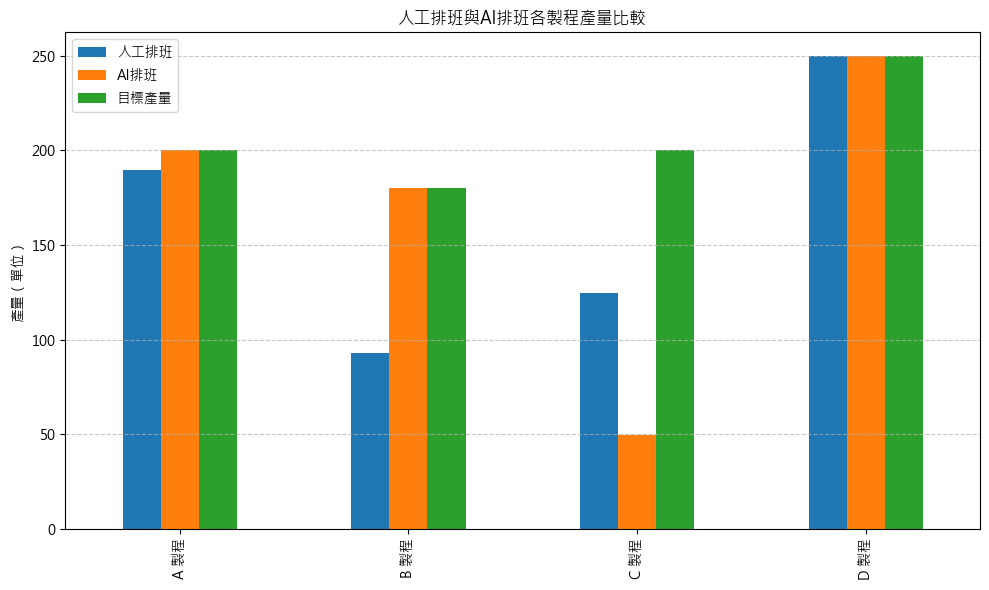


=== 人工排班表 ===
   工人    製程   工作時數    預估產量
0  小明  A 製程   4.44   66.67
1  小明  B 製程   5.56   55.56
2  阿宏  D 製程   6.25  125.00
3  阿宏  B 製程   3.75   37.50
4  小美  C 製程  10.00   80.00
5  小芸  A 製程   4.44   66.67
6  小芸  C 製程   5.56   44.44
7  大強  D 製程   6.25  125.00
8  大強  A 製程   3.75   56.25

=== AI排班表 ===
   工人    製程   工作時數    預估產量
0  小明  A 製程   5.83   87.50
1  小明  B 製程   4.17   41.67
2  阿宏  D 製程  10.00  200.00
3  小美  B 製程   3.83   38.33
4  小美  C 製程   6.17   49.33
5  小芸  B 製程  10.00  100.00
6  大強  A 製程   7.50  112.50
7  大強  D 製程   2.50   50.00


In [7]:
import pandas as pd
from pulp import LpProblem, LpVariable, LpMinimize, lpSum, LpStatus, value
import matplotlib.pyplot as plt
import numpy as np


plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 或使用 ['Microsoft JhengHei'] for Windows
plt.rcParams['axes.unicode_minus'] = False  # 解決負號無法顯示問題
# 基本資料 (同你之前提供)
workers = {
    '小明': ['A 製程', 'B 製程'],
    '阿宏': ['B 製程', 'D 製程'],
    '小美': ['B 製程', 'C 製程'],
    '小芸': ['A 製程', 'B 製程', 'C 製程'],
    '大強': ['A 製程', 'B 製程', 'C 製程', 'D 製程']
}

productivity = {
    'A 製程': 15,
    'B 製程': 10,
    'C 製程': 8,
    'D 製程': 20
}

target_output = {
    'A 製程': 200,
    'B 製程': 180,
    'C 製程': 200,
    'D 製程': 250
}

max_hours_per_worker = 10

# ----- 1. 人為排班模擬 -----

# 計算每個製程可操作人數
proc_worker_count = {p: sum(p in workers[w] for w in workers) for p in productivity.keys()}
# 製程依可操作人數排序(少的優先)
proc_sorted = sorted(proc_worker_count.items(), key=lambda x: x[1])

# 建立排班空表
human_schedule = {w: {} for w in workers}
# 每人尚餘工時
hours_left = {w: max_hours_per_worker for w in workers}

# 依製程排序，平均分配該製程工時給可操作人，直到產量接近目標
for p, count in proc_sorted:
    # 需要工時 = 目標產量 / 單位產能(每小時)
    need_hours = target_output[p] / productivity[p]

    # 找出可操作此製程且尚有工時可分配的人
    available_workers = [w for w in workers if p in workers[w] and hours_left[w] > 0]

    # 平均分配工時
    if not available_workers:
        print(f"警告：沒有工人能操作製程 {p}")
        continue
    per_worker_hours = need_hours / len(available_workers)

    # 分配並調整若超過剩餘工時則分配剩餘工時
    for w in available_workers:
        assign = min(per_worker_hours, hours_left[w])
        human_schedule[w][p] = assign
        hours_left[w] -= assign

# 剩餘工時，隨便分配給第一個可操作製程確保10小時
for w in workers:
    if hours_left[w] > 0:
        # 先找第一個可操作製程
        p = workers[w][0]
        human_schedule[w][p] = human_schedule[w].get(p, 0) + hours_left[w]
        hours_left[w] = 0

# 人為排班結果轉DataFrame
human_records = []
for w, tasks in human_schedule.items():
    for p, hrs in tasks.items():
        human_records.append({'工人': w, '製程': p, '工作時數': round(hrs, 2), '預估產量': round(hrs * productivity[p], 2)})

human_df = pd.DataFrame(human_records)

# ----- 2. AI排班 -----
model = LpProblem("AI_Worker_Scheduling", LpMinimize)

# 變數
work_vars = {(w, p): LpVariable(f"{w}_{p}", lowBound=0, upBound=max_hours_per_worker)
             for w in workers for p in workers[w]}

# 目標：盡量達成產量目標 -> 以各製程未達產量差異的平方和最小化
# 需要額外輔助變數表示誤差
error_vars_pos = {p: LpVariable(f"error_pos_{p}", lowBound=0) for p in target_output}
error_vars_neg = {p: LpVariable(f"error_neg_{p}", lowBound=0) for p in target_output}

# 目標函數 (誤差平方和，簡化為誤差正負和)
model += lpSum(error_vars_pos[p] + error_vars_neg[p] for p in target_output)

# 約束
# 每製程產量 = 工作時數 * 產能，允許正負誤差
for p in target_output:
    total_output = lpSum(work_vars[w, p] * productivity[p] for w in workers if (w, p) in work_vars)
    model += total_output + error_vars_neg[p] >= target_output[p]
    model += total_output - error_vars_pos[p] <= target_output[p]

# 每人工時必須等於10小時
for w in workers:
    model += lpSum(work_vars[w, p] for p in workers[w]) == max_hours_per_worker

# 求解
model.solve()

# AI排班結果整理
ai_schedule = []
for (w, p), var in work_vars.items():
    if var.varValue and var.varValue > 0:
        ai_schedule.append({
            "工人": w,
            "製程": p,
            "工作時數": round(var.varValue, 2),
            "預估產量": round(var.varValue * productivity[p], 2)
        })

ai_df = pd.DataFrame(ai_schedule)

# ----- 3. 比較圖 & 排班時間軸繪製函式 -----

def plot_gantt(df, title):
    schedule_sorted = df.sort_values(['工人', '製程']).copy()
    schedule_sorted['開始時間'] = 0
    for worker in schedule_sorted['工人'].unique():
        worker_mask = schedule_sorted['工人'] == worker
        hours_cumsum = schedule_sorted.loc[worker_mask, '工作時數'].cumsum()
        schedule_sorted.loc[worker_mask, '開始時間'] = hours_cumsum - schedule_sorted.loc[worker_mask, '工作時數']

    fig, ax = plt.subplots(figsize=(12, 6))

    colors = {
        'A 製程': '#1f77b4',  # 藍
        'B 製程': '#ff7f0e',  # 橘
        'C 製程': '#2ca02c',  # 綠
        'D 製程': '#d62728'   # 紅
    }

    yticks = []
    ylabels = []

    for i, worker in enumerate(schedule_sorted['工人'].unique()):
        worker_tasks = schedule_sorted[schedule_sorted['工人'] == worker]
        yticks.append(i)
        ylabels.append(worker)
        for _, row in worker_tasks.iterrows():
            ax.barh(i, row['工作時數'], left=row['開始時間'], color=colors[row['製程']], edgecolor='black')
            ax.text(row['開始時間'] + row['工作時數'] / 2, i, f"{row['製程']}\n{row['工作時數']}h",
                    ha='center', va='center', color='white', fontsize=9)

    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels)
    ax.set_xlabel("工作時數（小時）")
    ax.set_xlim(0, max_hours_per_worker)
    ax.set_title(title)
    ax.grid(axis='x', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

# 產量比較圖
def plot_output_comparison(human_df, ai_df):
    human_output = human_df.groupby('製程')['預估產量'].sum()
    ai_output = ai_df.groupby('製程')['預估產量'].sum()
    target = pd.Series(target_output)

    df_compare = pd.DataFrame({
        '人工排班': human_output,
        'AI排班': ai_output,
        '目標產量': target
    }).fillna(0)

    df_compare.plot(kind='bar', figsize=(10,6))
    plt.title("人工排班與AI排班各製程產量比較")
    plt.ylabel("產量（單位）")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# 執行繪圖
plot_gantt(human_df, "人工排班時間軸 ") #(Gantt Chart)
plot_gantt(ai_df, "AI排班時間軸 ") #(Gantt Chart)
plot_output_comparison(human_df, ai_df)

# 輸出排班表
print("\n=== 人工排班表 ===")
print(human_df)
print("\n=== AI排班表 ===")
print(ai_df)
